In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

# The following line allows for interactive plotting in Jupyter notebooks
# You need to install the ipympl package and restart your software for this to work
# Comment it out if you don't want interactive plots
%matplotlib widget  

from forced_hkb import forced_hkb_ode, simulate_forced_hkb_grid_params

We are going to simulate a forced Haken-Kelso-Bunz oscillator (Haken, Kelso & Bunz, 1985 for a description of the dynamics of the model; see Fuchs et al., 1996 for a description of the oscillator), defined as:
$$\ddot x + \epsilon \dot x + \omega_0^2 x + \gamma x^2 \dot x + \delta \dot x^3 = F \sin(\omega t) +\sqrt{Q} \xi(t),$$
where $x$, $\dot x$, $\ddot x$ are respectively the state variable, its first derivative and its second derivative; $\omega_0$ is the natural frequency of the oscillator and $\omega$ is the frequency of the forcing. Here, $\xi(t)$ denotes a gaussian white noise with strength $\sqrt{Q}$.

Notice that there is a second derivative and that the system is non autonomous (dependence on time through coupling and noise). Therefore, we need to introduce 2 new dimensions to the model to be able to code it properly (see Strogatz, 2024 section 1.2):
$$\begin{align*}
\dot x_1 & = -\epsilon x_1 - \omega_0^2 x_2 - \gamma x_2^2 x_1 - \delta x_1^3 + F \sin(\omega x_3) + \sqrt{Q} \xi(x_3), \\
\dot x_2 & = x_1, \\
\dot x_3 & = 1.
\end{align*}$$
The third dimension encodes for time and is used in the first dimension of the model.

In [20]:
# Set list of frequency and coupling strength values for the simulation
nb_params_values = 40
frequencies_list = np.linspace(2, 4, nb_params_values)
coupling_strengths_list = np.linspace(0.1, 1, nb_params_values)

# Set the intrinsic frequency of the oscillator
omega_0 = 3

t, x_list, phi_rel_list, stats_list = simulate_forced_hkb_grid_params(coupling_strengths_list, frequencies_list, omega_0=omega_0)

Time taken for the first frequency set: 0.09 minutes
Estimated time for the entire simulation: 3.73 minutes
Simulation progress: 10% (time elapsed: 0.37 minutes)
Simulation progress: 20% (time elapsed: 0.73 minutes)
Simulation progress: 30% (time elapsed: 1.09 minutes)
Simulation progress: 40% (time elapsed: 1.46 minutes)
Simulation progress: 50% (time elapsed: 1.82 minutes)
Simulation progress: 60% (time elapsed: 2.18 minutes)
Simulation progress: 70% (time elapsed: 2.55 minutes)
Simulation progress: 80% (time elapsed: 2.91 minutes)
Simulation progress: 90% (time elapsed: 3.27 minutes)
Total simulation time: 3.64 minutes


Text(0.5, 0, '$\\omega$')

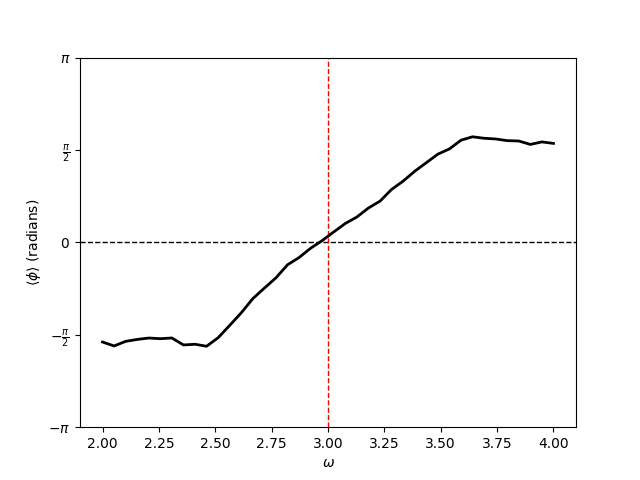

In [76]:
plt.figure()
plt.plot(frequencies_list, -stats_list[1,-1,:], "k", linewidth=2)
plt.axhline(0, color='k', linestyle='--', linewidth=1, zorder=0)
plt.axvline(omega_0, color='r', linestyle='--', linewidth=1, zorder=0)
# Y axis is in radians
plt.yticks(np.arange(-np.pi, np.pi + 0.1, np.pi/2),
           [r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
plt.ylabel(r"$\langle\phi\rangle$ (radians)")
plt.xlabel(r"$\omega$")

Let's verify the time series for a given coupling strength and coupling frequency.

Text(0, 0.5, '$\\phi$ (radians)')

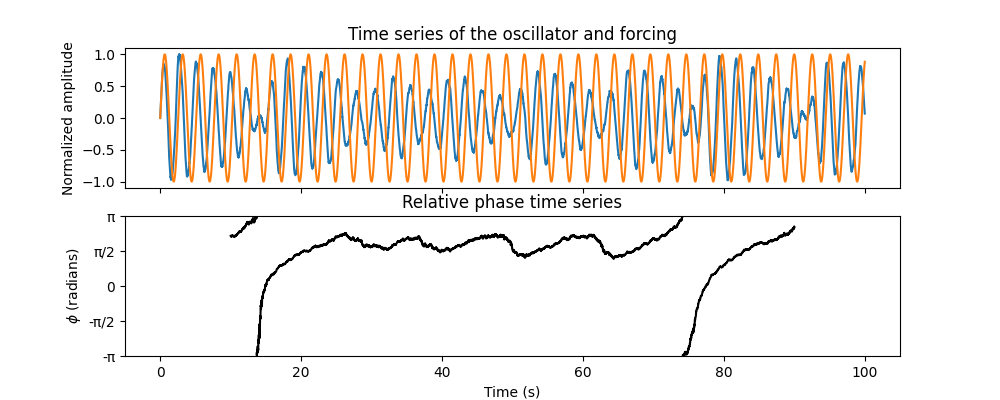

In [37]:
# Select coupling strength
F_idx = 30
F = coupling_strengths_list[F_idx] 

# Select frequency
freq_idx = 9
freq = frequencies_list[freq_idx] 
forcing_series = np.sin(freq * t)

# Get the time series for the selected parameters
x = x_list[:, F_idx, freq_idx,]
phi_rel = phi_rel_list[:, F_idx, freq_idx,]

# Plot the results
fig, axs = plt.subplots(2, 1, figsize=(10, 4), sharex=True)

axs[0].plot(t, x / max(x), label="Oscillator")
axs[0].plot(t, forcing_series, label="Forcing")
axs[0].set_title("Time series of the oscillator and forcing")
axs[0].set_ylabel("Normalized amplitude")

axs[1].plot(t[1000:-1000], phi_rel[1000:-1000], color="k")
axs[1].set_ylim([-np.pi, np.pi])
axs[1].set_title("Relative phase time series")
axs[1].set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
               labels=["-π", "-π/2", "0", "π/2", "π"])
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel(r"$\phi$ (radians)")


3.333333333333333 0.06598299500787112
3.641025641025641 0.9645009911159255


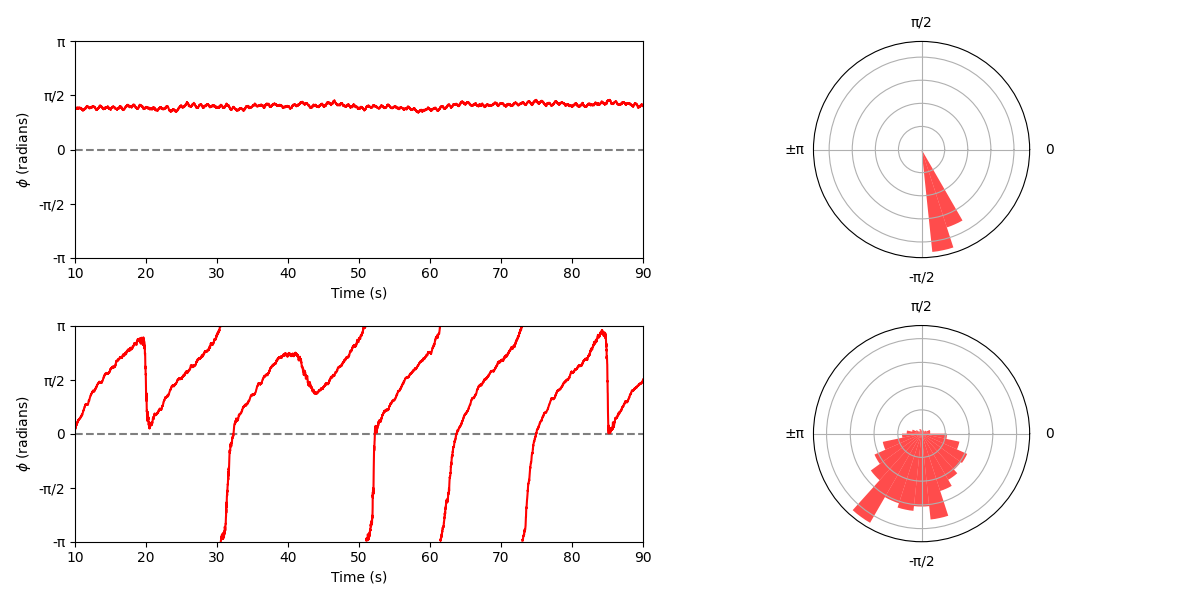

In [67]:
import matplotlib.gridspec as gridspec

freq_indices = [26, 32]
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(2, 3, width_ratios=[2, 0.1, 2])

for i, freq_idx in enumerate(freq_indices):
    freq = frequencies_list[freq_idx]
    print(freq, stats_list[0, F_idx, freq_idx])
    phi_rel = phi_rel_list[:, F_idx, freq_idx].copy()
    dphi = np.diff(phi_rel)
    mask = np.abs(dphi) > np.pi
    phi_rel[1:][mask] = np.nan

    # Time series subplot spanning 2 columns
    ax_ts = fig.add_subplot(gs[i, :2])
    ax_ts.plot(t[1000:-1000], -phi_rel[1000:-1000], color="red", linewidth=1.5)
    ax_ts.axhline(0, color="k", linestyle="--", zorder=0, alpha=0.5)
    ax_ts.set_ylabel(r"$\phi$ (radians)")
    ax_ts.set_xlabel("Time (s)")
    ax_ts.set_xlim([10, 90])
    ax_ts.set_ylim([-np.pi, np.pi])
    ax_ts.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
                     labels=["-π", "-π/2", "0", "π/2", "π"])

    # Polar histogram subplot in the third column
    ax_polar = fig.add_subplot(gs[i, 2], polar=True)
    num_bins = 30
    counts, bin_edges = np.histogram(phi_rel[1000:-1000], bins=num_bins, range=(-np.pi, np.pi))
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    ax_polar.bar(bin_centers, counts, width=2 * np.pi / num_bins, bottom=0.0, color='red', alpha=0.7)
    ax_polar.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2],
                        labels=["0", "π/2", "±π", "-π/2"])
    ax_polar.set_yticklabels([])

plt.tight_layout()


Now that we have verified that the numerical integration of the system gave correct results and that the relative phase was estimated correctly, let's plot the dispersion of the relative phase (SD $\phi$) for each combination of parameters. The vertical red dotted line represents the intrinsic frequency of the oscillator $\omega_0$.

We observe a reversed triangle centered around $\omega_0$ where SD $\phi$ is low. This is a region where the synchronization is stable; outside this region, the relative phase drifts. This region of synchronization is called an Arnold tongue (Arnol′d, 1961; for review, see Pikovsky, Rosenblum & Kurths, 2001).

Text(0.5, 0, 'Frequency')

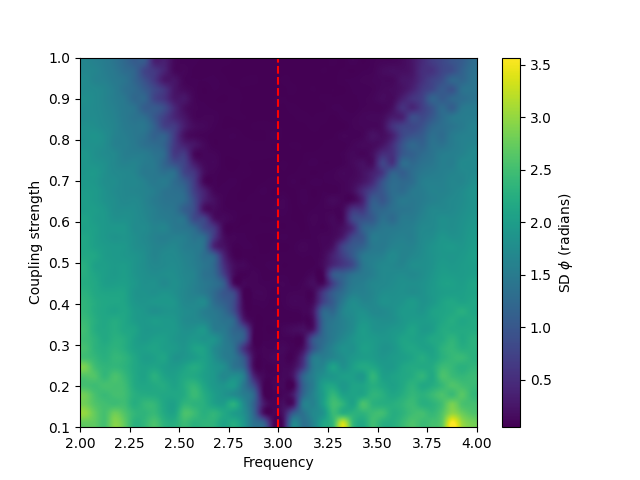

In [21]:
# Plot the dispersion of relative phase as a function of frequency and coupling strength
plt.figure()
plt.imshow(
    stats_list[0,:,:], 
    origin = 'lower',
    extent=[frequencies_list[0], frequencies_list[-1], coupling_strengths_list[0], coupling_strengths_list[-1]],
    interpolation = "spline16", 
    aspect = 'auto'
)
plt.axvline(omega_0, color='red', linestyle='--')
plt.colorbar(label=r'SD $\phi$ (radians)')
plt.ylabel("Coupling strength")
plt.xlabel("Frequency")

# References

Arnol′d, V. I. (1961). Small denominator I: on the mapping of a circle into itself. *Izvestiya Akademii Nauk SSSR Seriya Matematicheskaya, 25*(1), 21-86. 
> For an english translation of the paper, see Arnol′d, V. I. (1965). Small denominators. I. Mappings of the circumference onto itself. In V. I. Arnol′d, S. Adjan, S. Demuškin, Ju. Gurevič, S. Kemhadze, N. Klimov, Ju. Linnik, A. Malyšev, P. Novikov, D. Suprunenko, V. Tartakovskiĭ, & V. Tašbaev, *Eleven Papers on Number Theory, Algebra and Functions of a Complex Variable* (Vol. 46). American Mathematical Society. https://doi.org/10.1090/trans2/046

Fuchs, A., Jirsa, V. K., Haken, H., & Kelso, J. A. S. (1996). Extending the HKB-Model of coordinated movement to  oscillators with different eigenfrequencies. *Biological Cybernetics, 74*, 21-30. https://doi.org/10.1007/BF00199134

Haken, H., Kelso, J. A. S., & Bunz, H. (1985). A theoretical model of phase transitions in human hand movements. *Biological Cybernetics, 51*(5), Article 5. https://doi.org/10.1007/BF00336922

Pikovsky, A., Rosenblum, M., & Kurths, J. (2001). *Synchronization: A Universal Concept in Nonlinear Sciences* (1st edition). Cambridge University Press.

Strogatz, S. H. (2024). *Nonlinear Dynamics and Chaos: With Applications to Physics, Biology, Chemistry, and Engineering* (3rd ed.). CRC Press. https://doi.org/10.1201/9780429492563
